# Demystifying linear models

This notebook will cover linear regression, and all the fancy tricks that go along with it. By starting with simple linear models, rather than neural networks, we can learn about some of the associated techniques (e.g. regularisation) in a cleaner way.

As we will see, linear models can handle some pretty complicated problems while staying interpretable. The ability to quickly interpret our model will vastly out weigh its lack of complexity compared to some other  cutting edge algorithms.

We will start with a simple straight line fit and build our way up to industry standard modelling with the `prophet` package. Hopefully the interactive demonstrations in this notebook will make this tool seem less like magic...

> This notebook is heavily inspired by this fantastic [talk](https://youtu.be/68ABAU_V8qI?si=gHJaD7s88sX3YpWE), along with this notebook investigating cycling patterns in [Seattle](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/).

In [1]:
# imports 

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("./excel.mplstyle")
tl_colors = [
    "#00a88f",
    "#ff9da1",
    "#160078",
    "#ffc508",
    "#ff6120",
    "#004ff9",
    "#ac3200",
]

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
import ipywidgets as widgets
import pandas as pd
import arviz as az
import bambi as bmb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import datasets

import patsy

from prophet import Prophet
from prophet.plot import seasonality_plot_df
from prophet.utilities import regressor_coefficients

%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Straight line fit

This is normally what I thought of when someones says linear regression, simply a straight line fit through the data.
This can be described as:
$y = m \times x + c$

where $y$ is our target variable, $x$ is the feature, $c$ is the intercept and $m$ is the coefficient for $x$.

When we say linear regression, we really mean that the coefficients before the features are a constant number, e.g. $m = 1$

When we "fit" our model to the data, we are changing the values of the coefficients with the aim of minimising the error between the observed data and our predictions.

For example, in the demonstration below try finding the best combination of $c$ and $m$ that minimised the mean squared error (MSE).





In [2]:
example_scatter_data = pd.read_csv("./data/example_scatter.csv")

def linear_model(
        x,
        m,
        c
):
    return m * x + c

def update_linear(
    data,
    m,
    c
):
    
    fig, axs = plt.subplots(1,1)

    axs.scatter(data['x'], data['y'], color = 'black')

    xs = np.linspace(200, 600, 1000)

    total = linear_model(
        xs,
        m, 
        c
    )


    axs.plot(
        xs, 
        total,
        color = 'red',
        ls = '--'
    )


    axs.set_ylabel('y')

    pred_y = linear_model(
        data['x'],
        m,
        c
    )

    mse = np.mean((data['y'] - pred_y)**2)
    # sum_of_squares = np.sum((data['y'] - data['y'].mean())**2)

    # R2 = 1 - sum_of_residuals/sum_of_squares

    axs.set_title(f"MSE: {mse:.3f}")

    axs.set_xlim(180,600)
    axs.set_ylim(140,450)
    

m_slider = widgets.FloatSlider(min=-1, max=1, value=0.6, step=0.05, description="m", continuous_update=False)
c_slider = widgets.FloatSlider(min=-200, max=200, value=50, step=10, description="c", continuous_update=False)

In [3]:
# Use interactive
interactive_plot = interactive(
    update_linear,
    data = fixed(example_scatter_data),
    m = m_slider,
    c = c_slider
)

# Arrange the widgets horizontally
sliders = VBox([*interactive_plot.children[:-1]])

hbox_layout = HBox([interactive_plot.children[-1], sliders])

display(hbox_layout)

### Fitting a model

Instead of manually playing around with the coefficients we can "fit" the model. This automatically finds the coefficients that give the lowest error.

The mean squared error in the prediction vs real values can be written as:
$$
MSE = \sum_{i=1}^{n} (y_{i} - (m \times x_{i} + c))^{2}
$$

which is the sum of all the errors for each value, $i$, of the observed data. We minimisation this function with some calculus, giving us the exact solution. This is not something that is true for more complex models like neural networks. While they also try and minimise the loss, the solver can get stuck in a local minima, which is not necessarily the best solution.

You will notice that we are using a strange format to specify $y = m\times x + c$ as `y ~ 1 + x`.
This notation is standard for specifying regression formulas:
- 1 is converted into an intercept
- a coefficient is created to go infront of the x variable

This may seem like overkill, but will become very useful later on...

In [4]:
formula = "y ~ 1 + x"

y_train, X_train = patsy.dmatrices(formula, data=example_scatter_data)

# Create a linear regression model
model = LinearRegression(fit_intercept = False)

# Fit the model
model.fit(X_train, y_train)

# Make predictions (optional)
y_pred = model.predict(X_train)

# Evaluate the model (optional)
mse = mean_squared_error(y_train, y_pred)
print(f"Mean Squared Error: {mse}")

# Coefficients and Intercept
print(f"m: {model.coef_[0][1]:.1f}")
print(f"c: {model.coef_[0][0]:.1f}")

Mean Squared Error: 978.9642605739285
m: 0.6
c: 41.3


The beauty of linear regression is that we can know instantly make a statement about our problem:
- there is a baseline y value of 41.3
- for every 1 unit of x we increase the value of y by 0.6

This could help us answer questions like, for every £1 of ad spend we generate £X in sales.


# Dummy variable


> But what if our data shows some structure?

With some clever feature engineering we can create a whole host of new features with their own coefficients, allowing us to model more complex situations.

For example, I have created some fake data that has a clear weekly seasonality. How can we possibly model this with a straight line?

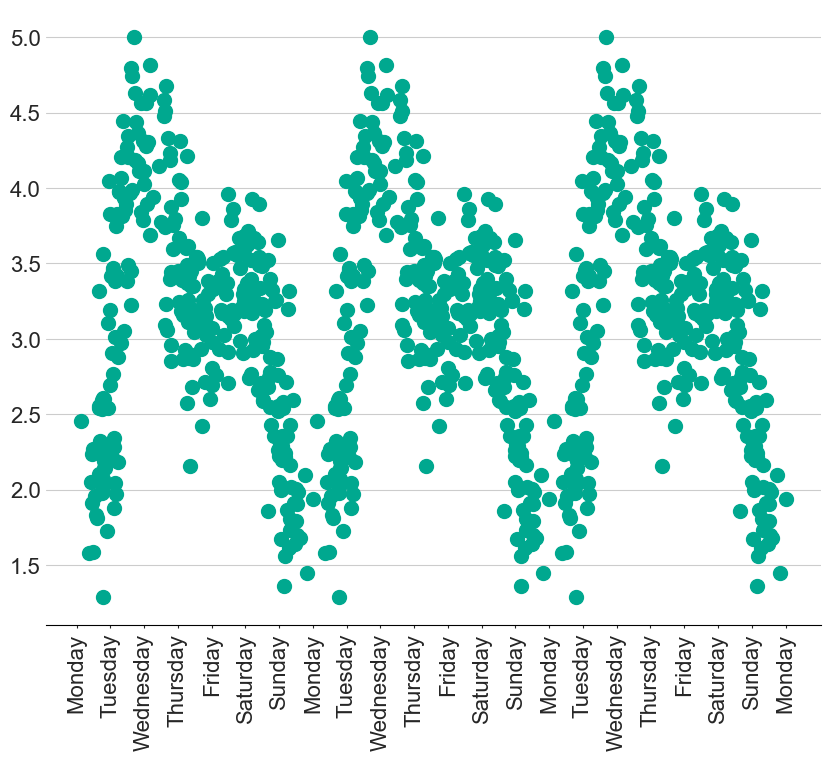

In [5]:
# create the data

data = pd.read_csv("./data/weekly_seasonality.csv")
#turn 0->1 into 0-7 (for days of the week)
data['x'] = 7*data['x']/data['x'].max()
data['y'] = 5*data['y']/data['y'].max()

extra_weeks = pd.DataFrame(
    {
        "y": np.concatenate((data['y'].values, data['y'].values)),
        "x": np.concatenate((data['x'].values+7, data['x'].values+ (2*7)))
        }
)

data = pd.concat([data, extra_weeks])
data = data.sort_values("x")
# data.head()

fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.scatter(data['x'], data['y'])

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
ticks = axs.set_xticks(np.arange(0, 21 + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, 21 + 1, 1)], rotation=90)


We can create a dummy variable for each day of the week. This function will be $=1$ on a certain day, and $=0$ on all other days. Including these features into our regression model means that we now have a coefficient before each of the dummy variables. **These coefficients control the height of each individual dummy variable**, allowing us to fit a seasonal pattern

In our regression, we can create a coefficient for each of these dummy variables, like so:
```python
df['x1'] = dummy(df['x'], 0)
df['x2'] = dummy(df['x'], 1)
df['x3'] = dummy(df['x'], 2)
df['x4'] = dummy(df['x'], 3)
df['x5'] = dummy(df['x'], 4)
df['x6'] = dummy(df['x'], 5)
df['x7'] = dummy(df['x'], 6)

formula = "y ~ 0 + x1 + x2 + x3 + x4 + x5 + x6 + x7"
```


Text(0, 0.5, 'y')

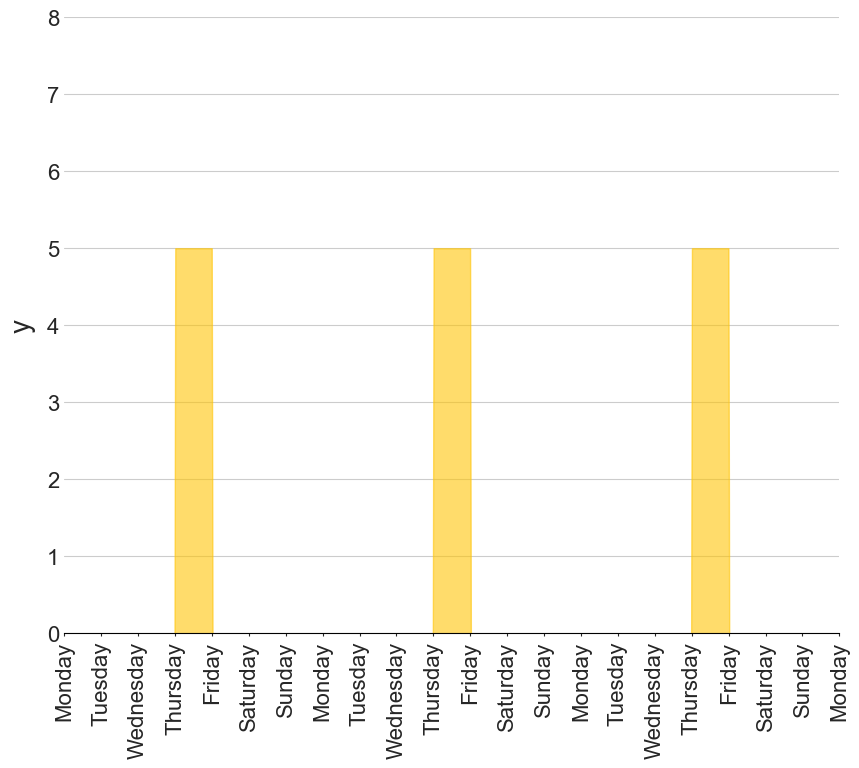

In [32]:
fig, axs = plt.subplots(1,1)

top_x = 7*3
xs = np.linspace(0,top_x, 1000)

alpha = 0.6
axs.fill_between(xs, 5 * dummy(xs, start= 3), alpha = alpha, color = tl_colors[3])

axs.set_xlim(0,top_x)
axs.set_ylim(0,8)

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
plt.xticks(np.arange(0, max(xs) + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, max(xs) + 1, 1)], rotation=90)

axs.set_ylabel('y')

In [6]:

def dummy(x, start, width = 1):
    x_mod = x % 7
    # Create a boolean array where True is set for elements within the specified range
    condition = (x_mod >= start) & (x_mod < start + width)

    # Convert the boolean array to an integer array (True becomes 1, False becomes 0)
    return condition.astype(int)

def dummy_model(
        x,
        C_1,
        C_2,
        C_3,
        C_4,
        C_5,
        C_6,
        C_7,
):
    return (
        C_1 * dummy(x, start= 0) + 
        C_2 * dummy(x, start= 1) + 
        C_3 * dummy(x, start= 2) + 
        C_4 * dummy(x, start= 3) + 
        C_5 * dummy(x, start= 4) + 
        C_6 * dummy(x, start= 5) + 
        C_7 * dummy(x, start= 6)
    )

def update_dummy(
    data,
    C_1,
    C_2,
    C_3,
    C_4,
    C_5,
    C_6,
    C_7,
):
    
    fig, axs = plt.subplots(1,1)

    axs.scatter(data['x'], data['y'], color = 'black')

    top_x = 7*3
    xs = np.linspace(0,top_x, 1000)

    alpha = 0.6
    axs.fill_between(xs, C_1 * dummy(xs, start= 0), alpha = alpha)
    axs.fill_between(xs, C_2 * dummy(xs, start= 1), alpha = alpha)
    axs.fill_between(xs, C_3 * dummy(xs, start= 2), alpha = alpha)
    axs.fill_between(xs, C_4 * dummy(xs, start= 3), alpha = alpha)
    axs.fill_between(xs, C_5 * dummy(xs, start= 4), alpha = alpha)
    axs.fill_between(xs, C_6 * dummy(xs, start= 5), alpha = alpha)
    axs.fill_between(xs, C_7 * dummy(xs, start= 6), alpha = alpha)

    total = dummy_model(
        xs,
        C_1, 
        C_2, 
        C_3, 
        C_4, 
        C_5, 
        C_6, 
        C_7
    )


    axs.plot(
        xs, 
        total,
        color = 'red',
        ls = '--'
    )

    axs.set_xlim(0,top_x)
    axs.set_ylim(0,6.5)

    # Define the days of the week
    days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    # Set xticks and labels
    plt.xticks(np.arange(0, max(xs) + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, max(xs) + 1, 1)], rotation=90)

    axs.set_ylabel('y')

    pred_y = dummy_model(
        data['x'],
        C_1,
        C_2, 
        C_3, 
        C_4, 
        C_5, 
        C_6, 
        C_7
    )

    mse = np.mean((data['y'] - pred_y)**2)
    # sum_of_squares = np.sum((data['y'] - data['y'].mean())**2)

    # R2 = 1 - sum_of_residuals/sum_of_squares

    axs.set_title(f"MSE: {mse:.3f}")
    

C_1_slider = widgets.FloatSlider(min=0, max=5, value=2.0, step=0.1, description="C1", continuous_update=False)
C_2_slider = widgets.FloatSlider(min=0, max=5, value=3.7, step=0.1, description="C2", continuous_update=False)
C_3_slider = widgets.FloatSlider(min=0, max=5, value=4.2, step=0.1, description="C3", continuous_update=False)
C_4_slider = widgets.FloatSlider(min=0, max=5, value=3.0, step=0.1, description="C4", continuous_update=False)
C_5_slider = widgets.FloatSlider(min=0, max=5, value=3.0, step=0.1, description="C5", continuous_update=False)
C_6_slider = widgets.FloatSlider(min=0, max=5, value=2.8, step=0.1, description="C6", continuous_update=False)
C_7_slider = widgets.FloatSlider(min=0, max=5, value=1.0, step=0.1, description="C7", continuous_update=False)

INTERACTIVE: Try adjusting the coefficients yourself to minimise the error in the figure below

In [7]:


# Use interactive
interactive_plot = interactive(
    update_dummy,
    data = fixed(data),
    C_1 = C_1_slider, 
    C_2 = C_2_slider, 
    C_3 = C_3_slider, 
    C_4 = C_4_slider, 
    C_5 = C_5_slider, 
    C_6 = C_6_slider, 
    C_7 = C_7_slider, 
)

# Arrange the widgets horizontally
sliders = VBox([*interactive_plot.children[:-1]])

hbox_layout = HBox([interactive_plot.children[-1], sliders])

display(hbox_layout)

Train a linear regression model with the same coefficients

In [8]:
df = data.copy(deep = True)

df['x1'] = dummy(df['x'], 0)
df['x2'] = dummy(df['x'], 1)
df['x3'] = dummy(df['x'], 2)
df['x4'] = dummy(df['x'], 3)
df['x5'] = dummy(df['x'], 4)
df['x6'] = dummy(df['x'], 5)
df['x7'] = dummy(df['x'], 6)

formula = "y ~ 0 + x1 + x2 + x3 + x4 + x5 + x6 + x7"

y_train, X_train = patsy.dmatrices(formula, data=df)

# Create a linear regression model
model = LinearRegression(fit_intercept = False)

# Fit the model
model.fit(X_train, y_train)

# Make predictions (optional)
y_pred = model.predict(X_train)

# Evaluate the model (optional)
mse = mean_squared_error(y_train, y_pred)
print(f"Mean Squared Error: {mse}")

coeffs = model.coef_[0]
for i, day in enumerate(days_of_week):
    print(f"{coeffs[i]:.2f} on {day}")

# Coefficients and Intercept
# print("Coefficients:", model.coef_)
# print("Intercept:", model.intercept_)

Mean Squared Error: 0.2808031608814921
2.36 on Monday
3.62 on Tuesday
3.93 on Wednesday
3.25 on Thursday
3.29 on Friday
3.04 on Saturday
2.10 on Sunday


So not only can we fit this seasonal pattern, but we can instantly tell that Wednesday is 1.8 units above Sunday!

Text(0, 0.5, 'y')

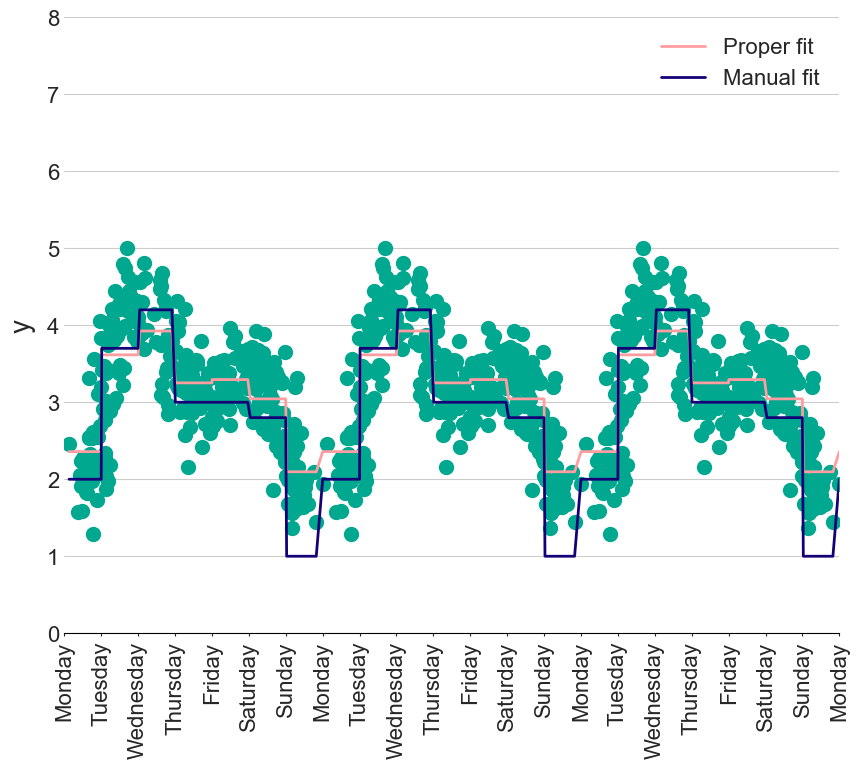

In [9]:
fig, axs = plt.subplots(1,1, figsize = (10,8))



axs.scatter(df['x'], df['y'])
axs.plot(df['x'], model.predict(X_train), color = tl_colors[1], label = 'Proper fit')
axs.plot(df['x'], dummy_model(df['x'], C_1_slider.value, C_2_slider.value,C_3_slider.value,C_4_slider.value,C_5_slider.value,C_6_slider.value,C_7_slider.value), color = tl_colors[2], label = 'Manual fit')
axs.legend()

top_x = 21
axs.set_xlim(0,top_x)
axs.set_ylim(0,8)

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
plt.xticks(np.arange(0, top_x + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, top_x + 1, 1)], rotation=90)

axs.set_ylabel('y')

# Radial Basis Function

While these dummy variables are useful to prove the points about coefficients representing the height of each function, they look a bit ugly. The step like nature means that we are saying that as soon as it goes 1 minute past midnight, we expect a significant change!

To create a smoother seasonality pattern, we can create a repeating Gaussian distribution centered around a day of the week (see below).

The formula for this Gaussian shape is:
$$
y = e^{- (x - \textrm{center})/(2 \times \textrm{width})}
$$

In [11]:
# def rbf(x, width, center):
#     x_mod = x % 7
#     center_mod = center % 7
#     return np.exp(- ((x_mod-center_mod)**2) / (2 * width))


def rbf(x, width, center):
    x_mod = x % 7
    center_mod = center % 7
    
    # Original Gaussian
    gauss = np.exp(-((x_mod - center_mod)**2) / (2 * width))
    
    # Gaussian shifted by +7
    gauss_plus = np.exp(-((x_mod - (center_mod + 7))**2) / (2 * width))
    
    # Gaussian shifted by -7
    gauss_minus = np.exp(-((x_mod - (center_mod - 7))**2) / (2 * width))
    
    # Sum the contributions
    return gauss + gauss_plus + gauss_minus

def rbf_model(
        x,
        C_1,
        C_2,
        C_3,
        C_4,
        C_5,
        C_6,
        C_7,
        width,
):
    return (
        C_1 * rbf(x, width=width, center = 0) + 
        C_2 * rbf(x, width=width, center = 1) + 
        C_3 * rbf(x, width=width, center = 2) + 
        C_4 * rbf(x, width=width, center = 3) + 
        C_5 * rbf(x, width=width, center = 4) + 
        C_6 * rbf(x, width=width, center = 5) + 
        C_7 * rbf(x, width=width, center = 6)
    )

def update_rbf(
    data,
    C_1,
    C_2,
    C_3,
    C_4,
    C_5,
    C_6,
    C_7,
    width
):
    
    fig, axs = plt.subplots(1,1)

    axs.scatter(data['x'], data['y'], color = 'black')

    top_x = 7*3
    xs = np.linspace(0,top_x, 1000)

    alpha = 0.6
    axs.fill_between(xs, C_1 * rbf(xs, width = width, center= 0), alpha = alpha)
    axs.fill_between(xs, C_2 * rbf(xs, width = width, center= 1), alpha = alpha)
    axs.fill_between(xs, C_3 * rbf(xs, width = width, center= 2), alpha = alpha)
    axs.fill_between(xs, C_4 * rbf(xs, width = width, center= 3), alpha = alpha)
    axs.fill_between(xs, C_5 * rbf(xs, width = width, center= 4), alpha = alpha)
    axs.fill_between(xs, C_6 * rbf(xs, width = width, center= 5), alpha = alpha)
    axs.fill_between(xs, C_7 * rbf(xs, width = width, center= 6), alpha = alpha)

    total = rbf_model(
        xs,
        C_1, 
        C_2, 
        C_3, 
        C_4, 
        C_5, 
        C_6, 
        C_7,
        width=width
    )


    axs.plot(
        xs, 
        total,
        color = 'red',
        ls = '--'
    )

    axs.set_xlim(0,top_x)
    axs.set_ylim(0,8)

    # Define the days of the week
    days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    # Set xticks and labels
    plt.xticks(np.arange(0, max(xs) + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, max(xs) + 1, 1)], rotation=90)

    axs.set_ylabel('y')

    pred_y = rbf_model(
        data['x'],
        C_1,
        C_2, 
        C_3, 
        C_4, 
        C_5, 
        C_6, 
        C_7,
        width
    )

    mse = np.mean((data['y'] - pred_y)**2)
    # sum_of_squares = np.sum((data['y'] - data['y'].mean())**2)

    # R2 = 1 - sum_of_residuals/sum_of_squares

    axs.set_title(f"MSE: {mse:.3f}")
    

C_1_slider = widgets.FloatSlider(min=0, max=5, value=1.0, step=0.1, description="C1", continuous_update=False)
C_2_slider = widgets.FloatSlider(min=0, max=5, value=2.2, step=0.1, description="C2", continuous_update=False)
C_3_slider = widgets.FloatSlider(min=0, max=5, value=3.7, step=0.1, description="C3", continuous_update=False)
C_4_slider = widgets.FloatSlider(min=0, max=5, value=2.4, step=0.1, description="C4", continuous_update=False)
C_5_slider = widgets.FloatSlider(min=0, max=5, value=1.7, step=0.1, description="C5", continuous_update=False)
C_6_slider = widgets.FloatSlider(min=0, max=5, value=2.3, step=0.1, description="C6", continuous_update=False)
C_7_slider = widgets.FloatSlider(min=0, max=5, value=1.4, step=0.1, description="C7", continuous_update=False)

width_slider = widgets.FloatSlider(min=0.01, max=0.5, value=0.3, step=0.01, description="Width")

Text(0, 0.5, 'y')

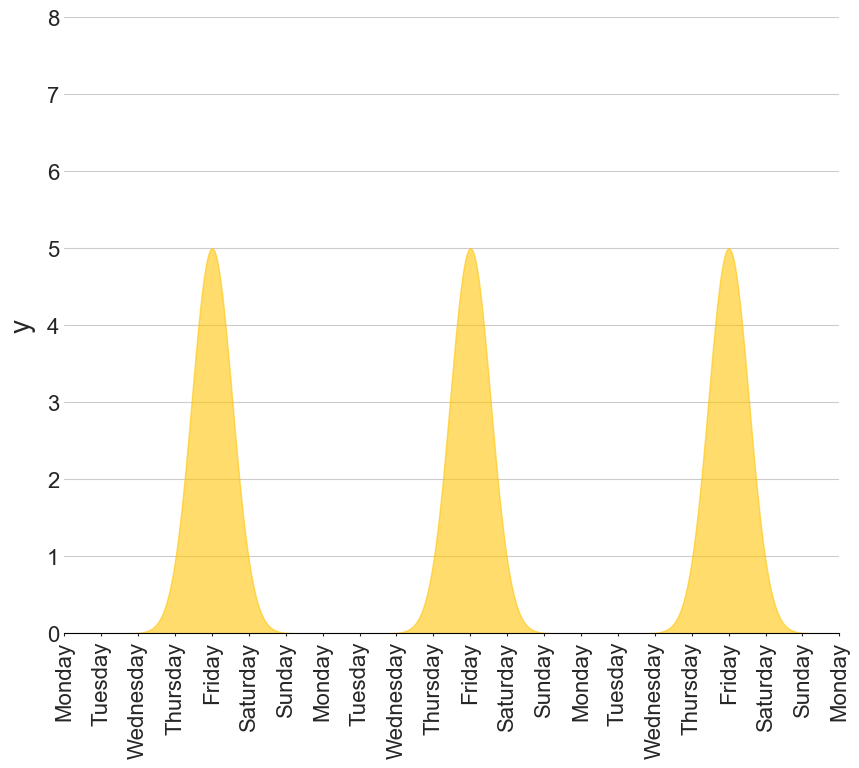

In [12]:
fig, axs = plt.subplots(1,1)

top_x = 7*3
xs = np.linspace(0,top_x, 1000)

alpha = 0.6
axs.fill_between(xs, 5 * rbf(xs, width = 0.3, center= 4), alpha = alpha, color = tl_colors[3])

axs.set_xlim(0,top_x)
axs.set_ylim(0,8)

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
plt.xticks(np.arange(0, max(xs) + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, max(xs) + 1, 1)], rotation=90)

axs.set_ylabel('y')

INTERACTIVE: Adjust the coefficients **and** width to get the best fit

In [13]:
# Use interactive
interactive_plot = interactive(
    update_rbf,
    data = fixed(data),
    C_1 = C_1_slider, 
    C_2 = C_2_slider, 
    C_3 = C_3_slider, 
    C_4 = C_4_slider, 
    C_5 = C_5_slider, 
    C_6 = C_6_slider, 
    C_7 = C_7_slider, 
    width = width_slider
)

# Arrange the widgets horizontally
sliders = VBox([*interactive_plot.children[:-1]])

hbox_layout = HBox([interactive_plot.children[-1], sliders])

display(hbox_layout)

Fitting the model properly shows that we can improve the error over the dummy variable model!

Once again, this is still very interpretable

Proper fit
MSE: 0.199
0.91 on Monday
1.98 on Tuesday
3.61 on Wednesday
2.40 on Thursday
2.18 on Friday
2.66 on Saturday
1.84 on Sunday

Manual fit
MSE: 0.340
0.90 on Monday
2.20 on Tuesday
3.70 on Wednesday
2.40 on Thursday
1.70 on Friday
2.30 on Saturday
1.40 on Sunday


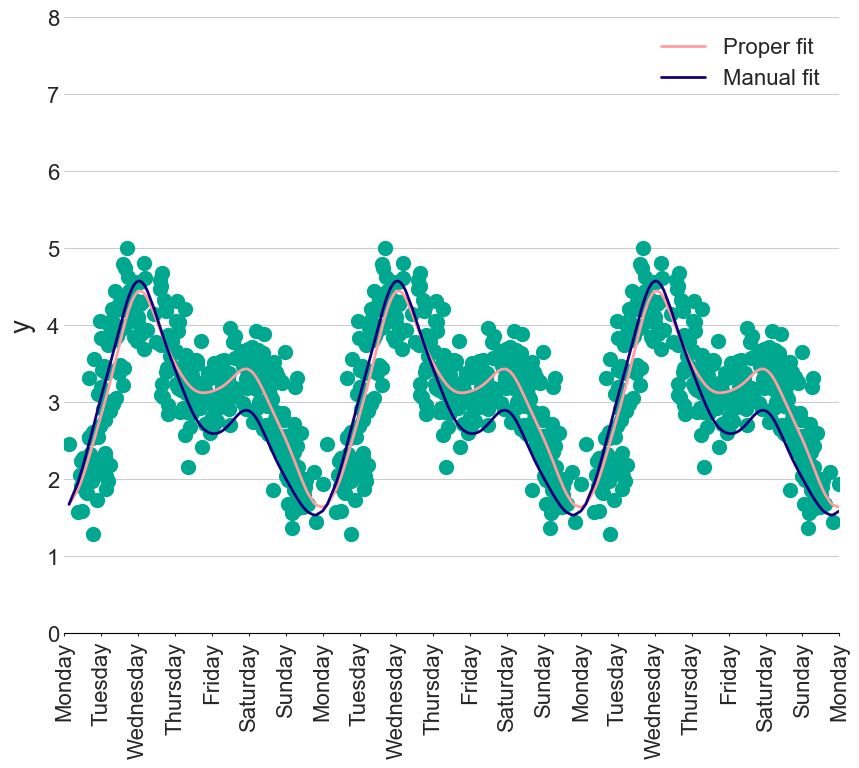

In [14]:
df = data.copy(deep = True)

width = 0.3

df['x1'] = rbf(df['x'], width = width, center = 0)
df['x2'] = rbf(df['x'], width = width, center = 1)
df['x3'] = rbf(df['x'], width = width, center = 2)
df['x4'] = rbf(df['x'], width = width, center = 3)
df['x5'] = rbf(df['x'], width = width, center = 4)
df['x6'] = rbf(df['x'], width = width, center = 5)
df['x7'] = rbf(df['x'], width = width, center = 6)

formula = "y ~ 0 + x1 + x2 + x3 + x4 + x5 + x6 + x7"

y_train, X_train = patsy.dmatrices(formula, data=df)

# Create a linear regression model
model = LinearRegression(fit_intercept = False)

# Fit the model
model.fit(X_train, y_train)

# Make predictions (optional)
y_pred = model.predict(X_train)

fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.scatter(df['x'], df['y'])
axs.plot(df['x'], model.predict(X_train), color = tl_colors[1], label = 'Proper fit')
manual_pred = rbf_model(df['x'], C_1_slider.value, C_2_slider.value,C_3_slider.value,C_4_slider.value,C_5_slider.value,C_6_slider.value,C_7_slider.value, width=width)
axs.plot(df['x'], manual_pred, color = tl_colors[2], label = 'Manual fit')
axs.legend()

top_x = 21
axs.set_xlim(0,top_x)
axs.set_ylim(0,8)

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
plt.xticks(np.arange(0, top_x + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, top_x + 1, 1)], rotation=90)

axs.set_ylabel('y')

print("Proper fit")
mse = mean_squared_error(y_train, y_pred)
print(f"MSE: {mse:.3f}")
coeffs = model.coef_[0]
for i, day in enumerate(days_of_week):
    print(f"{coeffs[i]:.2f} on {day}")

print('')
print("Manual fit")
mse = mean_squared_error(y_train, manual_pred)
print(f"MSE: {mse:.3f}")
slider_list = [C_1_slider, C_2_slider,C_3_slider,C_4_slider,C_5_slider,C_6_slider,C_7_slider]
coeffs = model.coef_[0]
for slider, day in zip(slider_list, days_of_week):
    print(f"{slider.value:.2f} on {day}")

### Hyperparameter tuning

You may have noticed that we know have an extra variable `width`, which controls the width of our individual Gaussian functions. This variable is not actually part of the Linear regression, but is used to generate the features that the model learns from. This is therefore a `hyperparameter` and is something we can **tune**.

The most basic form of hyperparameter tuning is called a `GridSearch`. This simply loops over different possible hyperparameter values and sees which one gives the lowest error, i.e is the best.

> Sidenote: lowest error does not always equal **best**, see this [post](https://koaning.io/posts/mean-squared-terror/) as an example 
<div>
<img src="https://koaning.io/posts/mean-squared-terror/ivory.png" width="500"/>
</div>

100%|██████████| 5/5 [00:00<00:00, 24.80it/s]


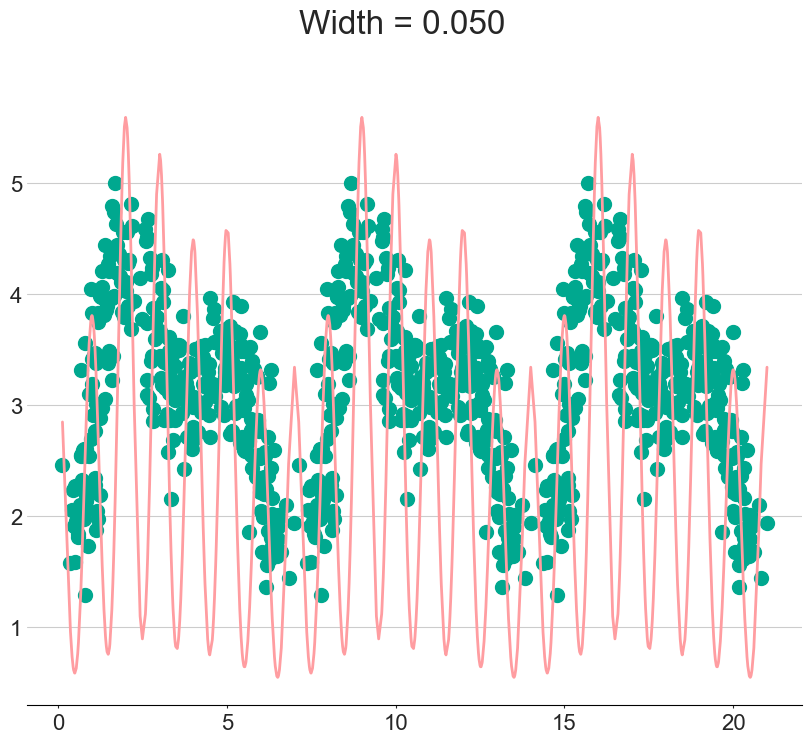

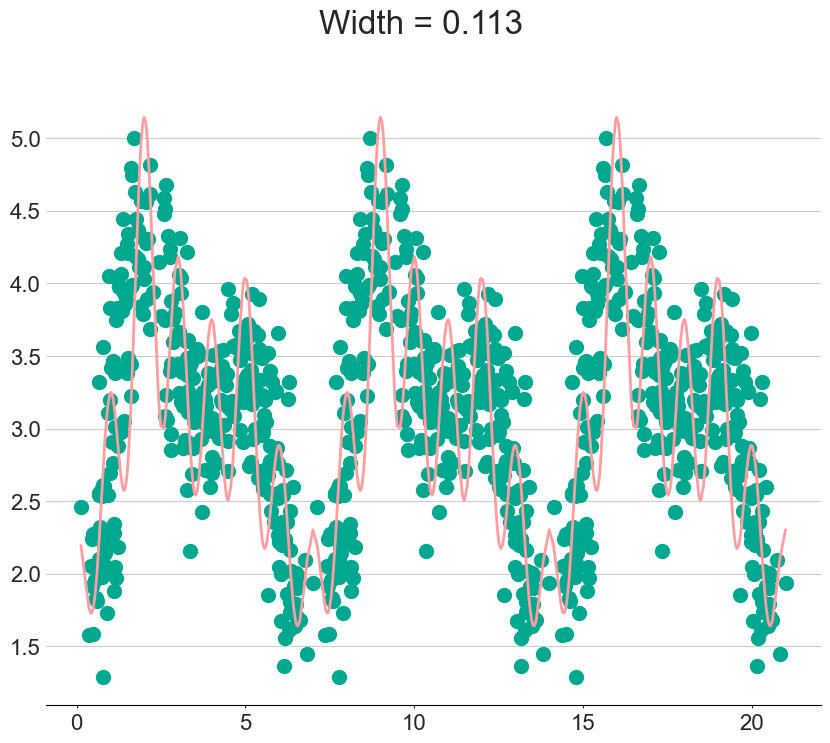

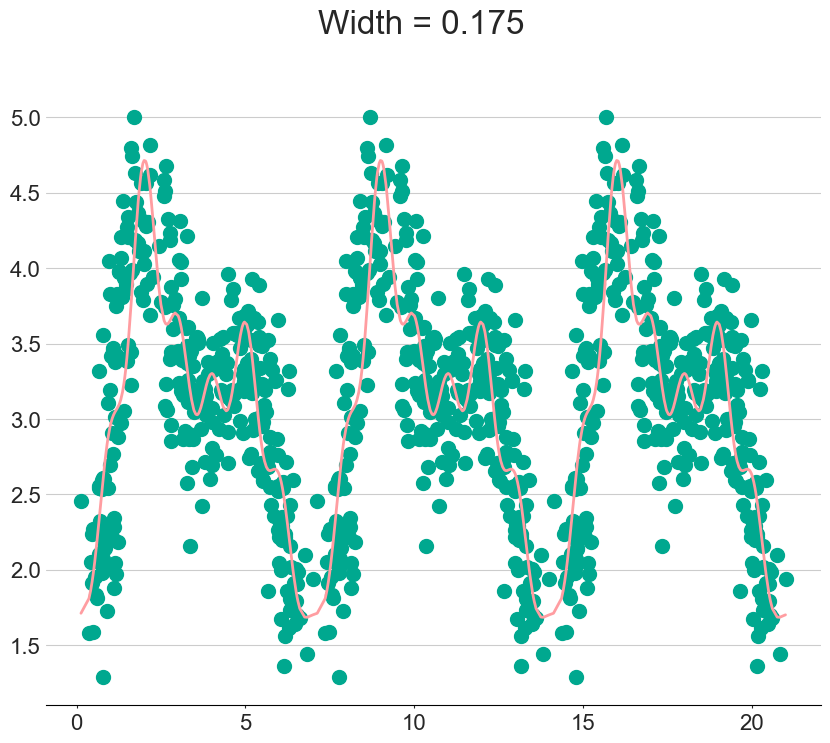

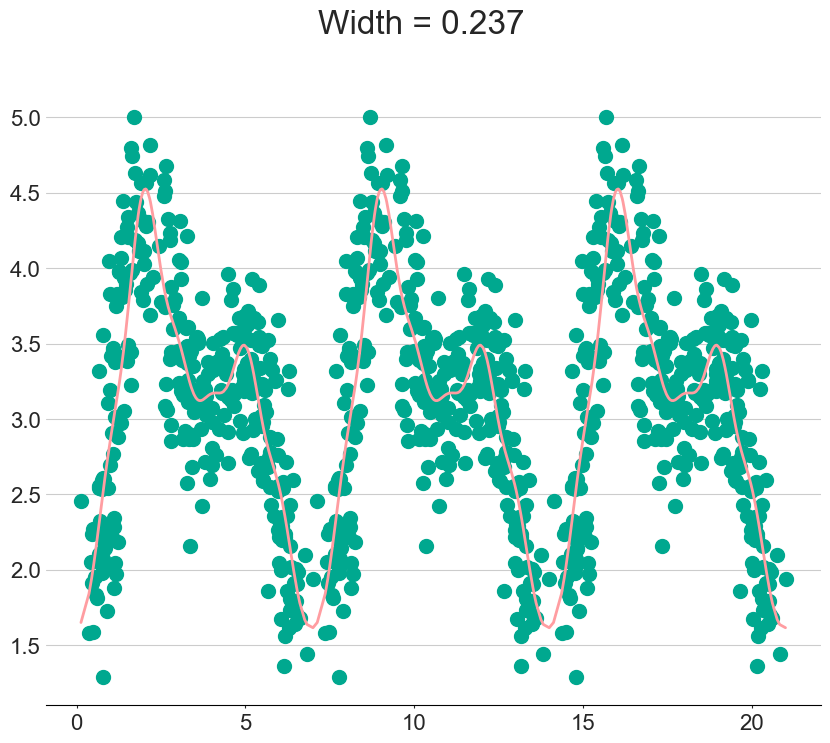

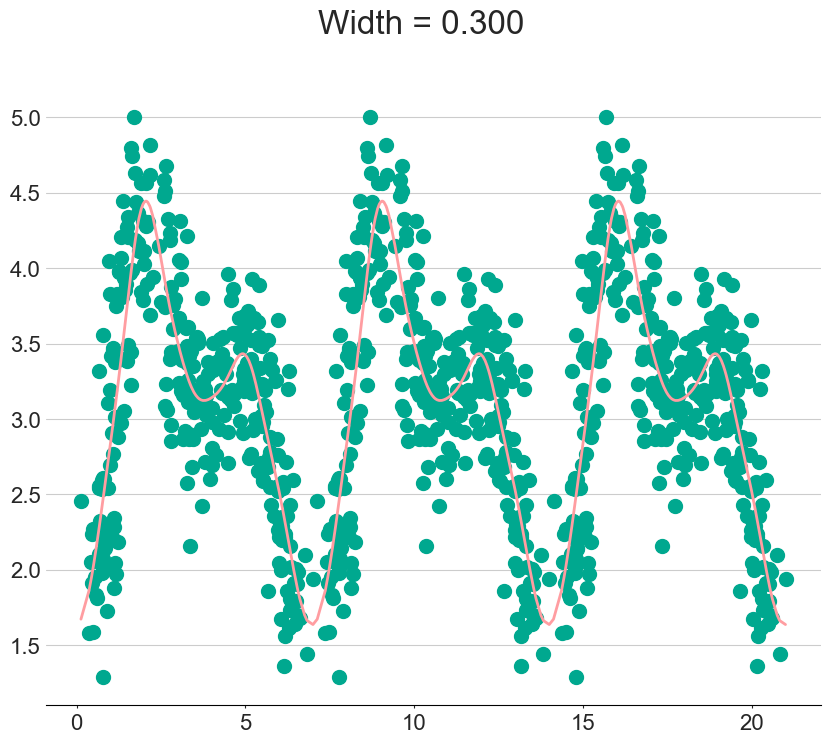

In [15]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm


%matplotlib inline

def fit_model(data, width, plot = False):
    df = data.copy(deep = True)

    df['x1'] = rbf(df['x'], width = width, center = 1)
    df['x2'] = rbf(df['x'], width = width, center = 2)
    df['x3'] = rbf(df['x'], width = width, center = 3)
    df['x4'] = rbf(df['x'], width = width, center = 4)
    df['x5'] = rbf(df['x'], width = width, center = 5)
    df['x6'] = rbf(df['x'], width = width, center = 6)
    df['x7'] = rbf(df['x'], width = width, center = 7)

    formula = "y ~ 0 + x1 + x2 + x3 + x4 + x5 + x6 + x7"

    y_train, X_train = patsy.dmatrices(formula, data=df)

    # Create a linear regression model
    model = LinearRegression(fit_intercept = False)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions (optional)
    y_pred = model.predict(X_train)

    # Evaluate the model (optional)
    mse = mean_squared_error(y_train, y_pred)

    if plot:
        fig, axs = plt.subplots(1,1, figsize = (10,8))

        axs.scatter(df['x'], df['y'])
        axs.plot(df['x'], model.predict(X_train), color = tl_colors[1], label = 'Proper fit')

        fig.suptitle(f"Width = {width:.3f}")

    return mse


mse_list = []
widths = np.linspace(0.05, 0.3, 5)

for test_width in tqdm(widths):
    mse = fit_model(data, test_width, True)
    mse_list.append(mse)


We can look at the MSE as a function of the `width` parameter

Text(0.5, 0, 'Width hyperparameter')

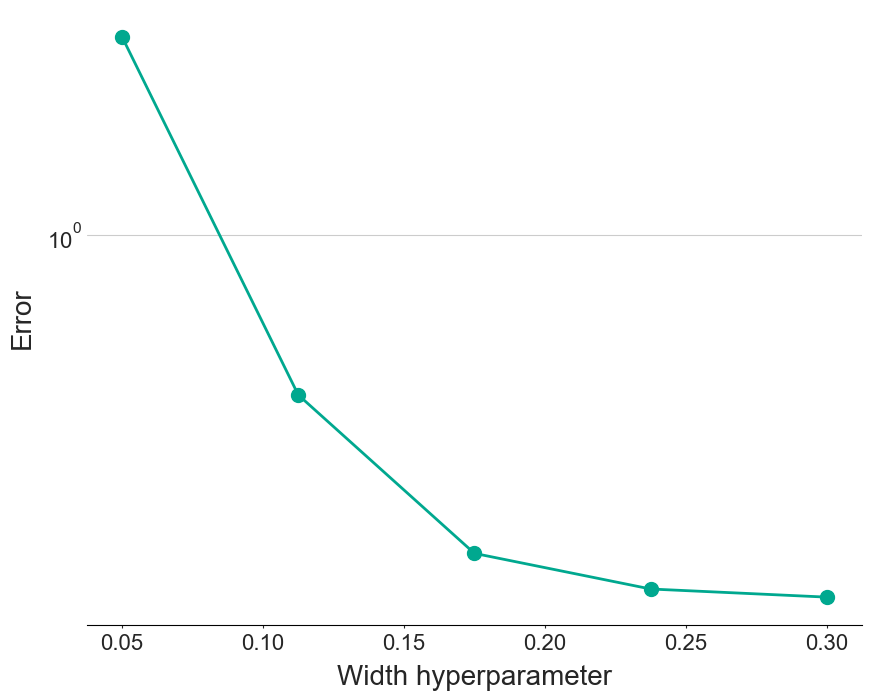

In [49]:

%matplotlib inline
fig , axs = plt.subplots(1,1)

axs.plot(widths, mse_list, marker = 'o')
axs.set_yscale('log')

axs.set_ylabel("Error")
axs.set_xlabel("Width hyperparameter")

There are many other ways to tune the hyperparameters, see this [guide](https://scikit-learn.org/stable/modules/grid_search.html).

### Trying bayesian fit here

> At this point, you might be wondering what are the uncertainties on these coefficients? 

Thankfully, we can also fit our model within a Bayesian framework which will provide a uncertainty estimate. Very briefly, Bayes' theorem allows you to mathematically update the probability of an event ($P(E)$) happening based on some new data (D).
$$
P(E|\textbf{D}) = P(E) \frac{P(\textbf{D} |E)}{P(\textbf{D})}
$$

For example, we might be playing a game of "heads or tails" in which I have to guess the coin face. I give you the benefit of the doubt and initially believe that there is a 50/50 chance of the coin being fair, i.e. P(Fair) = 0.5. This is called my `prior` assumption.

If the coin is fair, then on each coin flip the probability of getting heads is 50%. So the probability of $n$ heads in a row is equal to $P(H|\textrm{Fair}) = 0.5^{n}$
We will assume that if the coin is not fair the probability of $n$ heads is $P(H|\textrm{Not Fair}) = 0.75^{n}$

On each coin flip, I can update my beliefs to get a `posterior` probability, i.e. P(Event|Data)

Doing the maths, we can say that:
$$
P(\textrm{Not Fair}|3H) = (0.75^{3} \times 0.5) / (0.75^{3} \times 0.5 + 0.5^{3} \times 0.5) = 77\%
$$


Using this analogy, we start of by assuming a prior distribution for each of our linear regression coefficients (usually just a Gaussian). We then use Bayes' theorem to update our beliefs of these coefficients, given the observed data. With each new data point, we get a better understanding of the posterior distribution for each function!

Also, we don't have to use the standard Gaussian priors. We can actually set up the priors to include knowledge we already have about the problem, i.e. at Trainline we know the retention rate is roughly this from other experiments... This is incredibly powerful and not something that can be done with normal fitting routines.

> WARNING! this can be extremely slow, so don't run this if you want to use your computer for 5 minutes

You can see how we are using the same regression formula, but this time we are creating a `bambi` model, which is technically a `pyMC` model. Read their [documentation](https://www.pymc.io/welcome.html) for more information about the fitting procedure, and why it can be so slow.

In [50]:
df = data.copy(deep = True)

width = 0.3

df['x1'] = rbf(df['x'], width = width, center = 1)
df['x2'] = rbf(df['x'], width = width, center = 2)
df['x3'] = rbf(df['x'], width = width, center = 3)
df['x4'] = rbf(df['x'], width = width, center = 4)
df['x5'] = rbf(df['x'], width = width, center = 5)
df['x6'] = rbf(df['x'], width = width, center = 6)
df['x7'] = rbf(df['x'], width = width, center = 7)

# Initialize the fixed effects only model
bayes_model = bmb.Model('y ~ 0 + x1 + x2 + x3 + x4 + x5 + x6 + x7)', df)

# Fit the model using 1000 on each of 4 chains
results = bayes_model.fit(draws=1000, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x1, x2, x3, x4, x5, x6, x7]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 191 seconds.


c:\Users\ronanl\AppData\Local\anaconda3\envs\linear_models\Lib\site-packages\arviz\utils.py:142: UserWarning: Items starting with ~: ['x'] have not been found and will be ignored
  warnings.warn(


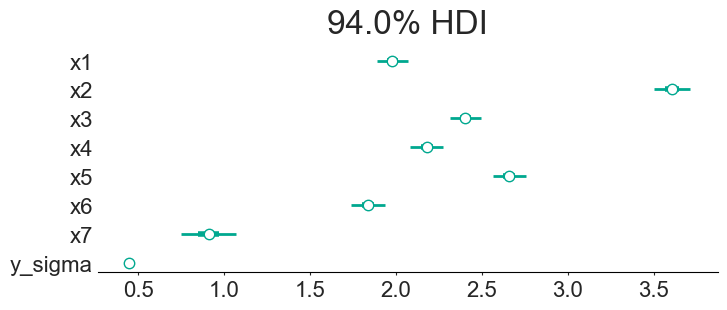

In [51]:
az.plot_forest(results, var_names=["~x"], figsize=(8, 3), combined=True);

In [52]:

# Key summary and diagnostic info on the model parameters
coeffs = az.summary(results, kind="stats")
coeffs

,mean,sd,hdi_3%,hdi_97%
x1,1.979,0.048,1.888,2.068
x2,3.606,0.057,3.499,3.709
x3,2.402,0.048,2.312,2.493
x4,2.179,0.052,2.081,2.275
x5,2.659,0.051,2.566,2.757
x6,1.838,0.053,1.739,1.938
x7,0.909,0.087,0.746,1.071
y_sigma,0.448,0.010,0.429,0.467


We can now see the confidence intervals for our fit. This allows us to quote things as "we are 97% confident that Sunday gives an extra 0.746 to 1.071 units"

We can also say things like,  "we are the least sure about the 7th day"

The extra `y_sigma` is the amount of noise in our data. It is very sure of the noise, probably because I made this fake data with a single noise parameter...

## Fourier

Another useful trick to modelling seasonality is with Fourier components. This is used more widely than the Radial Basis Functions in the previous section, less prone to overfitting.

Any function can be represented as a sum of infinitely many sine and cosine waves added together, known as a Fourier transform. You can explore this idea with this interactive [guide](https://www.jezzamon.com/fourier/index.html)

We can create a new feature for each of these sine and cosine waves. The coefficient for each of these variables will represent their fourier coefficient and is the amplitude of that individual sine wave.

In [53]:
from IPython.display import IFrame
IFrame("https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2019/fourier-series/fourier_intro_2.mp4", width="560", height="315" )

In [16]:
n_order = 2
periods = df["x"] / 7

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
fourier_features

,sin_order_1,cos_order_1,sin_order_2,cos_order_2
211,1.134221e-01,0.993547,2.253803e-01,0.974271
212,3.207819e-01,0.947153,6.076591e-01,0.794198
201,3.612420e-01,0.932472,6.736962e-01,0.739008
155,3.864503e-01,0.922310,7.128542e-01,0.701312
204,3.986125e-01,0.917119,7.311506e-01,0.682216
...,...,...,...,...
484,-3.885724e-01,0.921418,-7.160754e-01,0.698023
481,-3.426348e-01,0.939469,-6.437893e-01,0.765203
480,-2.196319e-01,0.975583,-4.285382e-01,0.903524
465,-1.556390e-01,0.987814,-3.074848e-01,0.951553


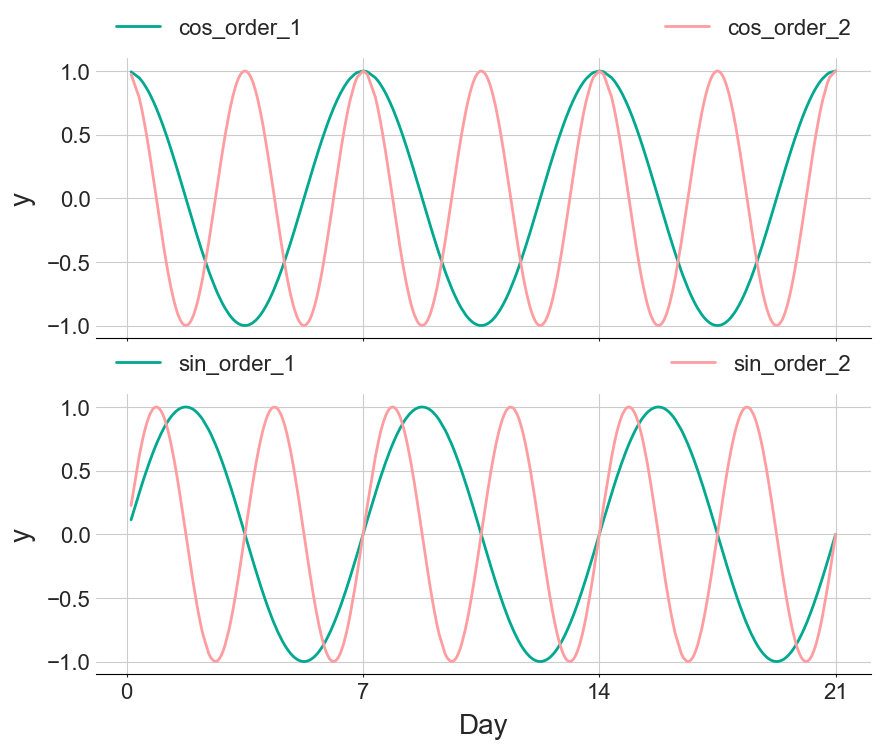

In [17]:
fig, axs = plt.subplots(2,1, sharex=True)

for col in fourier_features.keys():
    if col[:3] == 'cos':
        axs[0].plot(df['x'], fourier_features[col], label = col)
    else:
        axs[1].plot(df['x'], fourier_features[col], label = col)

axs[0].set_ylabel('y')
axs[1].set_ylabel('y')

axs[1].set_xlabel('Day')

axs[1].set_xticks([0,7,14,21])
axs[0].grid(True)
axs[1].grid(True)

axs[0].legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2)
axs[1].legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2)


In [23]:

def fourier_component(periods, func, order):
    return getattr(np, func)(2 * np.pi * periods * order)

def fourier_model(
        x,
        C_cos_1,
        C_sin_1,
        C_cos_2,
        C_sin_2
    ):
    return (
        C_cos_1 * fourier_component(x/7, "cos", 1) + 
        C_sin_1 * fourier_component(x/7, "sin", 1) + 
        C_cos_2 * fourier_component(x/7, "cos", 2) + 
        C_sin_2 * fourier_component(x/7, "sin", 2)
    )



def update_fourier(
    data,
    C_cos_1,
    C_sin_1,
    C_cos_2,
    C_sin_2,
):
    
    fig, axs = plt.subplots(1,1)

    axs.scatter(data['x'], data['y'] , color = 'black')

    top_x = 7*3
    xs = np.linspace(0,top_x, 1000)

    lw = 6
    axs.plot(xs, C_cos_1 * fourier_component(xs/7, "cos", 1), lw = lw)
    axs.plot(xs, C_sin_1 * fourier_component(xs/7, "sin", 1), lw = lw)
    axs.plot(xs, C_cos_2 * fourier_component(xs/7, "cos", 2), lw = lw)
    axs.plot(xs, C_sin_2 * fourier_component(xs/7, "sin", 2), lw = lw)
    

    total = fourier_model(
        xs,
        C_cos_1,
        C_sin_1,
        C_cos_2,
        C_sin_2,
    ) + data['y'].mean()


    axs.plot(
        xs, 
        total,
        color = 'red',
        ls = '--'
    )

    axs.set_xlim(0,top_x)
    axs.set_ylim(-8,8)

    # Define the days of the week
    days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    # Set xticks and labels
    plt.xticks(np.arange(0, max(xs) + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, max(xs) + 1, 1)], rotation=90)

    axs.set_ylabel('y')

    pred_y = fourier_model(
        data['x'],
        C_cos_1,
        C_sin_1,
        C_cos_2,
        C_sin_2,
    ) + data['y'].mean()

    mse = np.mean((data['y'] - pred_y)**2)
    # sum_of_squares = np.sum((data['y'] - data['y'].mean())**2)

    # R2 = 1 - sum_of_residuals/sum_of_squares

    axs.set_title(f"MSE: {mse:.3f}")
    

C_cos_1_slider = widgets.FloatSlider(min=-1, max=1, value=-0.78, step=0.1, description="C1 Cos", continuous_update=False)
C_sin_1_slider = widgets.FloatSlider(min=-1, max=1, value=0.38, step=0.1, description="C1 Sin", continuous_update=False)
C_cos_2_slider = widgets.FloatSlider(min=-1, max=1, value=-0.5, step=0.1, description="C2 Cos", continuous_update=False)
C_sin_2_slider = widgets.FloatSlider(min=-1, max=1, value=0, step=0.1, description="C2 Sin", continuous_update=False)

INTERACTIVE: Try changing the coefficients. You will notice that it is much less intuitive than before

In [24]:


# Use interactive
interactive_plot = interactive(
    update_fourier,
    data = fixed(data),
    C_cos_1 = C_cos_1_slider, 
    C_sin_1 = C_sin_1_slider, 
    C_cos_2 = C_cos_2_slider, 
    C_sin_2 = C_sin_2_slider
)

# Arrange the widgets horizontally
sliders = VBox([*interactive_plot.children[:-1]])

hbox_layout = HBox([interactive_plot.children[-1], sliders])

display(hbox_layout)

Let's just let the Linear regression find the best values

In [25]:
df = data.copy(deep = True)


df['cos_1'] = fourier_component(df['x']/7, "cos", 1)
df['sin_1'] = fourier_component(df['x']/7, "sin", 1)
df['cos_2'] = fourier_component(df['x']/7, "cos", 2)
df['sin_2'] = fourier_component(df['x']/7, "sin", 2)

formula = "y ~ 1 + cos_1 + sin_1 + cos_2 + sin_2"

y_train, X_train = patsy.dmatrices(formula, data=df)

# Create a linear regression model
model = LinearRegression(fit_intercept = False)


# Fit the model
model.fit(X_train, y_train)

# Make predictions (optional)
y_pred = model.predict(X_train)

# Evaluate the model (optional)
mse = mean_squared_error(y_train, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

coeffs = model.coef_[0]
print(f"Intercept: {coeffs[0]:.2f}")
for coeff, name in zip(coeffs[1:], ["cos_1", "sin_1", "cos_2", "sin_2"]):
    print(f"{coeff:.2f} for {name}")

Mean Squared Error: 0.199
Intercept: 3.04
-0.78 for cos_1
0.38 for sin_1
-0.66 for cos_2
-0.11 for sin_2


Text(0, 0.5, 'y')

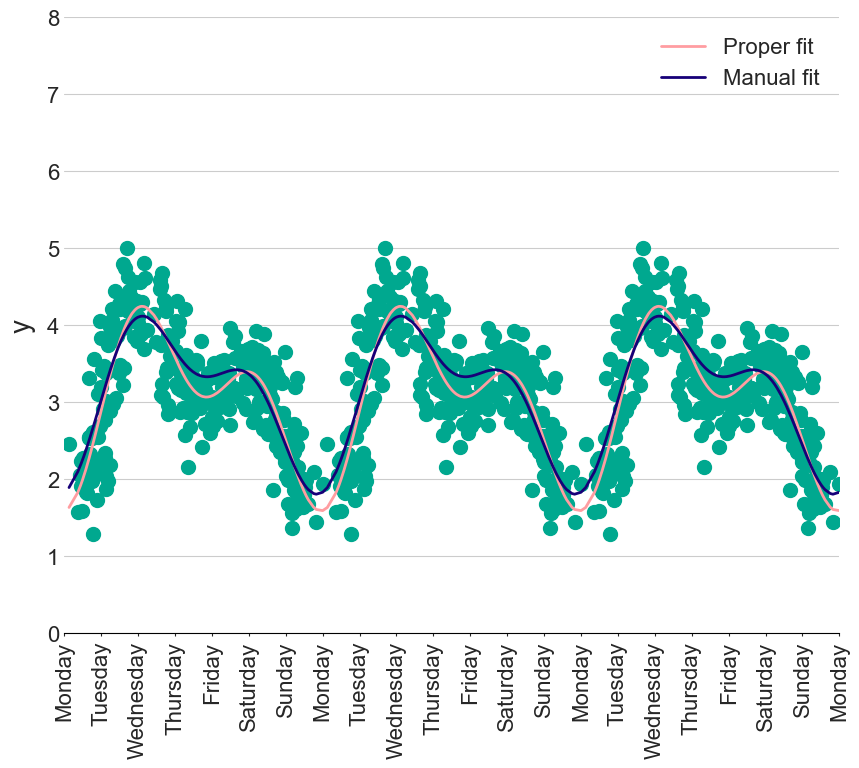

In [26]:
fig, axs = plt.subplots(1,1, figsize = (10,8))



axs.scatter(df['x'], df['y'])
axs.plot(df['x'], model.predict(X_train), color = tl_colors[1], label = 'Proper fit')
axs.plot(df['x'],  df['y'].mean() + fourier_model(df['x'], C_cos_1_slider.value, C_sin_1_slider.value,C_cos_2_slider.value,C_sin_2_slider.value), color = tl_colors[2], label = 'Manual fit')
axs.legend()

top_x = 21
axs.set_xlim(0,top_x)
axs.set_ylim(0,8)

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
plt.xticks(np.arange(0, top_x + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, top_x + 1, 1)], rotation=90)

axs.set_ylabel('y')

# Weighting

> What if I don't trust old data as much as recently taken data?

Within our model we can give an `importance` to each of the measurements. A common technique is to create an exponentially decaying importance to give less weight to the older measurements. Again, this is a type of `hyperparameter` we could tune

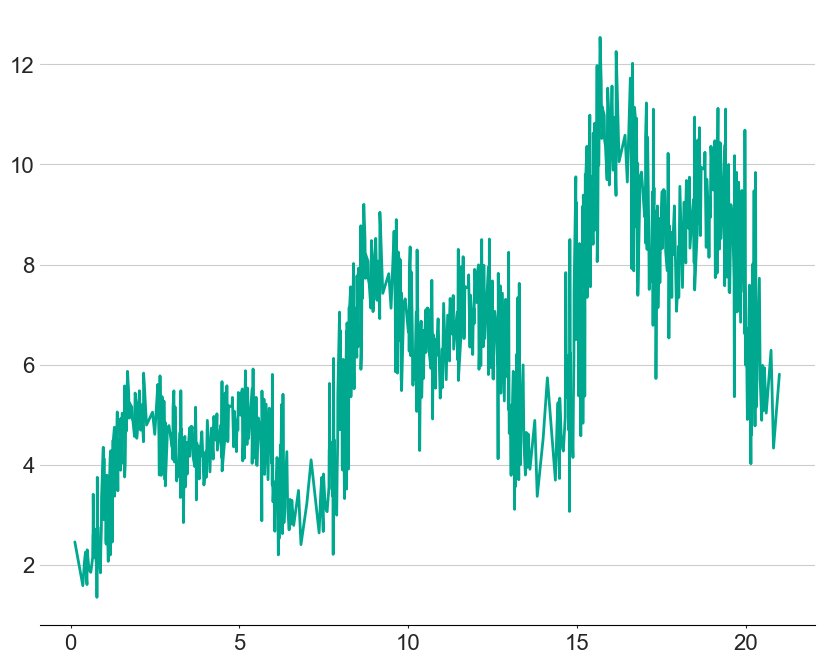

In [27]:
data['y_growth'] = data['y'] * np.linspace(1,3,data.shape[0])


fig, axs = plt.subplots(1,1)

axs.plot(data['x'], data['y_growth'])

In [28]:
df = data.copy(deep = True)


df['cos_1'] = fourier_component(df['x']/7, "cos", 1)
df['sin_1'] = fourier_component(df['x']/7, "sin", 1)
df['cos_2'] = fourier_component(df['x']/7, "cos", 2)
df['sin_2'] = fourier_component(df['x']/7, "sin", 2)

alpha = 0.5
df['importance'] = np.exp(alpha * (df['x'] - df['x'].max()))

formula = "y_growth ~ 1 + cos_1 + sin_1 + cos_2 + sin_2"

y_train, X_train = patsy.dmatrices(formula, data=df)

# Create a linear regression model with weighting
model_weighted = LinearRegression(fit_intercept = False)
# Fit the model
model_weighted.fit(X_train, y_train, sample_weight=df['importance'])

# Create a linear regression model
model = LinearRegression(fit_intercept = False)
# Fit the model
model.fit(X_train, y_train)

# Make predictions (optional)
y_pred = model_weighted.predict(X_train)

# Evaluate the model_weighted (optional)
mse = mean_squared_error(y_train, y_pred)
coeffs = model.coef_[0]
print(f"Intercept: {coeffs[0]:.2f}")
for coeff, name in zip(coeffs[1:], ["cos_1", "sin_1", "cos_2", "sin_2"]):
    print(f"{coeff:.2f} for {name}")

Intercept: 6.05
-1.55 for cos_1
0.10 for sin_1
-1.30 for cos_2
-0.39 for sin_2


Text(0, 0.5, 'y')

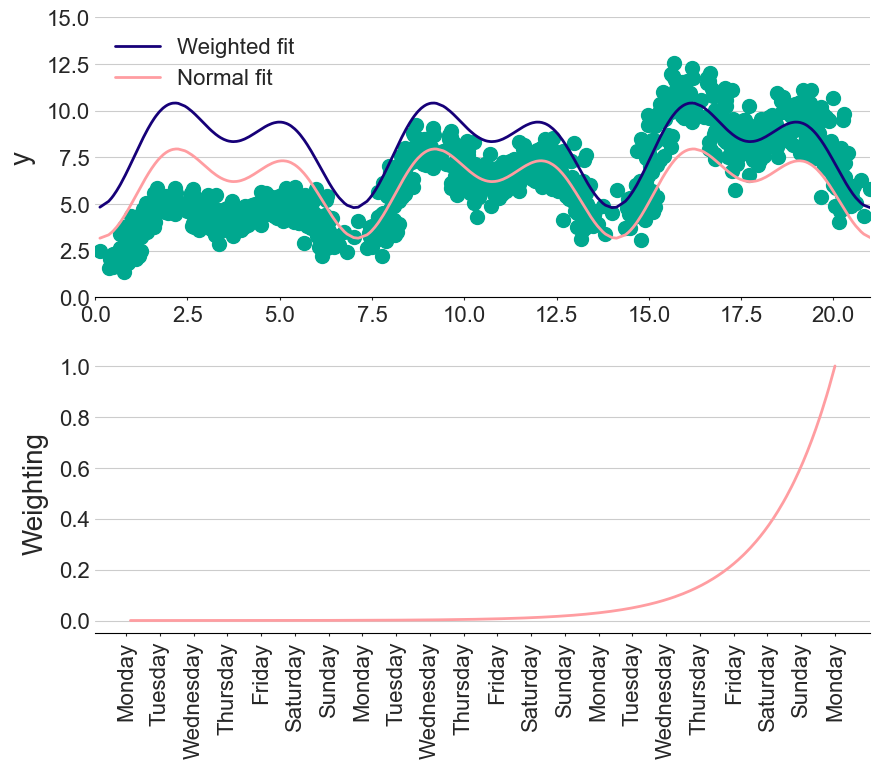

In [65]:
fig, axs = plt.subplots(2,1, figsize = (10,8))



axs[0].scatter(df['x'], df['y_growth'])
axs[0].plot(df['x'], model_weighted.predict(X_train), color = tl_colors[2], label = 'Weighted fit')
axs[0].plot(df['x'], model.predict(X_train), color = tl_colors[1], label = 'Normal fit')
axs[0].legend()

axs[1].plot(df['x'], df['importance'], color = tl_colors[1], label = 'Normal fit')
axs[1].set_ylabel("Weighting")

top_x = 21
axs[0].set_xlim(0,top_x)
axs[0].set_ylim(0,15)

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
plt.xticks(np.arange(0, top_x + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, top_x + 1, 1)], rotation=90)

axs[0].set_ylabel('y')

# Fancier regression terms

As I said earlier, the formulas like `y ~ 1 + x` can do some fancy things, as explained in this [guide](https://patsy.readthedocs.io/en/latest/formulas.html)

One cool thing we can do is include interaction terms between the different variables. For example, what if we knew that our seasonality changed over time, like the example below.

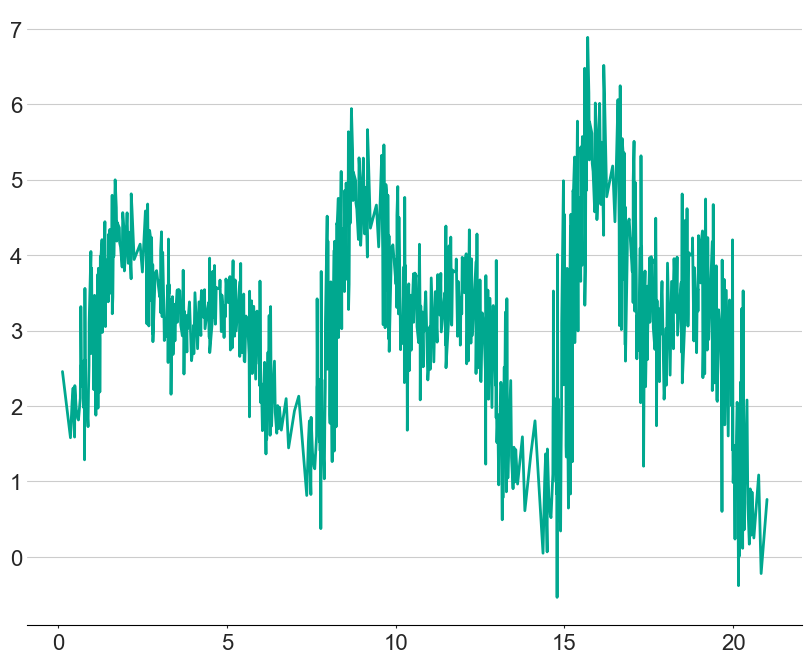

In [66]:
data = pd.read_csv("./data/weekly_seasonality.csv")
#turn 0->1 into 0-7 (for days of the week)
data['x'] = 7*data['x']/data['x'].max()
data['y'] = 5*data['y']/data['y'].max()

extra_weeks = pd.DataFrame(
    {
        "y": np.concatenate(( (data['y'].values - data['y'].mean())*1.5 + data['y'].mean(), (data['y'].values - data['y'].mean())*2 + data['y'].mean())),
        "x": np.concatenate((data['x'].values+7, data['x'].values+ (2*7)))
        }
)

data = pd.concat([data, extra_weeks])
data = data.sort_values("x")

plt.figure()
plt.plot(data['x'], data['y'])

We can model this by using the `*` operator like so:

`y ~ 0 + x*cos_1`

This autogenerates the coefficients for `x`, `cos_1` and the interaction between `x:cos_1` 

Mean Squared Error: 1.033
Coefficient of x: -0.01
Coefficient of cos_1: -0.41
Coefficient of x interacting with cos_1: -0.04


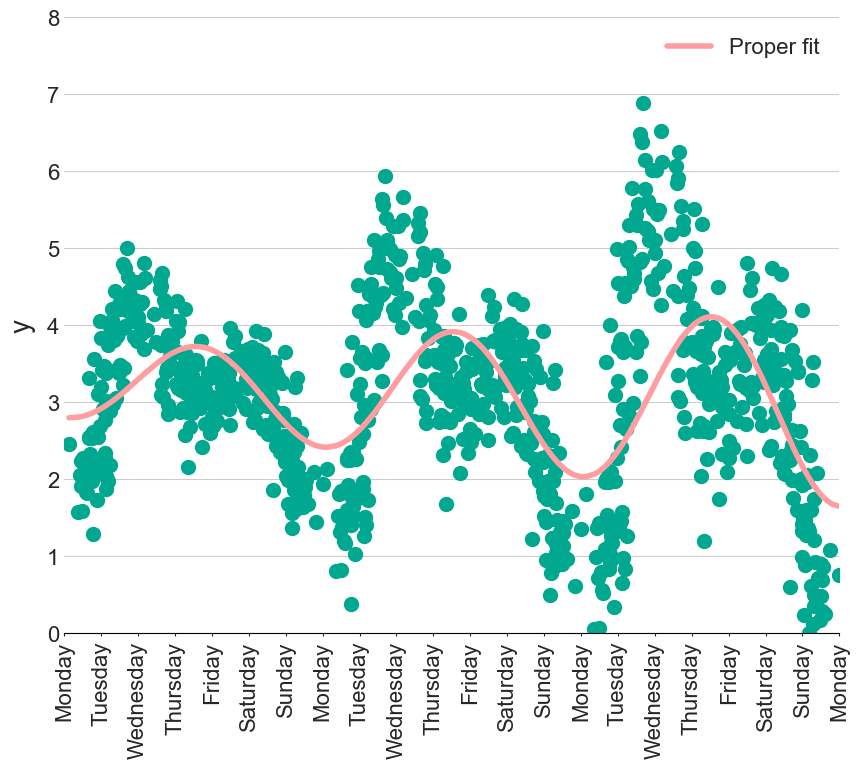

In [72]:
df = data.copy(deep = True)

df['cos_1'] = fourier_component(df['x']/7, "cos", 1)
df['sin_1'] = fourier_component(df['x']/7, "sin", 1)
df['cos_2'] = fourier_component(df['x']/7, "cos", 2)
df['sin_2'] = fourier_component(df['x']/7, "sin", 2)

# formula = "y ~ x * (cos_1 + sin_1 + cos_2 + sin_2)"
formula = "y ~ 0 + x*cos_1"

y_train, X_train = patsy.dmatrices(formula, data=df)

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions (optional)
y_pred = model.predict(X_train)

# Evaluate the model (optional)
mse = mean_squared_error(y_train, y_pred)


# Coefficients and Intercept
# print("Coefficients:", model.coef_)
# print("Intercept:", model.intercept_)

fig, axs = plt.subplots(1,1, figsize = (10,8))



axs.scatter(df['x'], df['y'])
axs.plot(df['x'], model.predict(X_train), color = tl_colors[1], label = 'Proper fit', lw= 4)
axs.legend()

top_x = 21
axs.set_xlim(0,top_x)
axs.set_ylim(0,8)

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
plt.xticks(np.arange(0, top_x + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, top_x + 1, 1)], rotation=90)

axs.set_ylabel('y')

print(f"Mean Squared Error: {mse:.3f}")
coeffs = model.coef_[0]
print(f"Coefficient of x: {coeffs[0]:.2f}")
print(f"Coefficient of cos_1: {coeffs[1]:.2f}")
print(f"Coefficient of x interacting with cos_1: {coeffs[2]:.2f}")


For this simple interaction between x and cos_1, we can interpret the coefficients as:
- For every 1 unit of x, y will reduce by 0.01 (negative slope straight line)
- The base amplitude for the cos1 variable is -0.41
- For every unit of x this amplitude will reduce by another -0.04 (making the amplitude larger) 

For the proper fit, we can easily include all the interaction terms like so:

`y ~ x * (cos_1 + sin_1 + cos_2 + sin_2)`

Mean Squared Error: 0.49354370210538523
Coefficients: [[ 0.         -0.00224563 -0.65746595  0.30001563 -0.62648673 -0.17348369
  -0.04805612  0.02651944 -0.03686036 -0.00546497]]
Intercept: [3.0565755]


Text(0, 0.5, 'y')

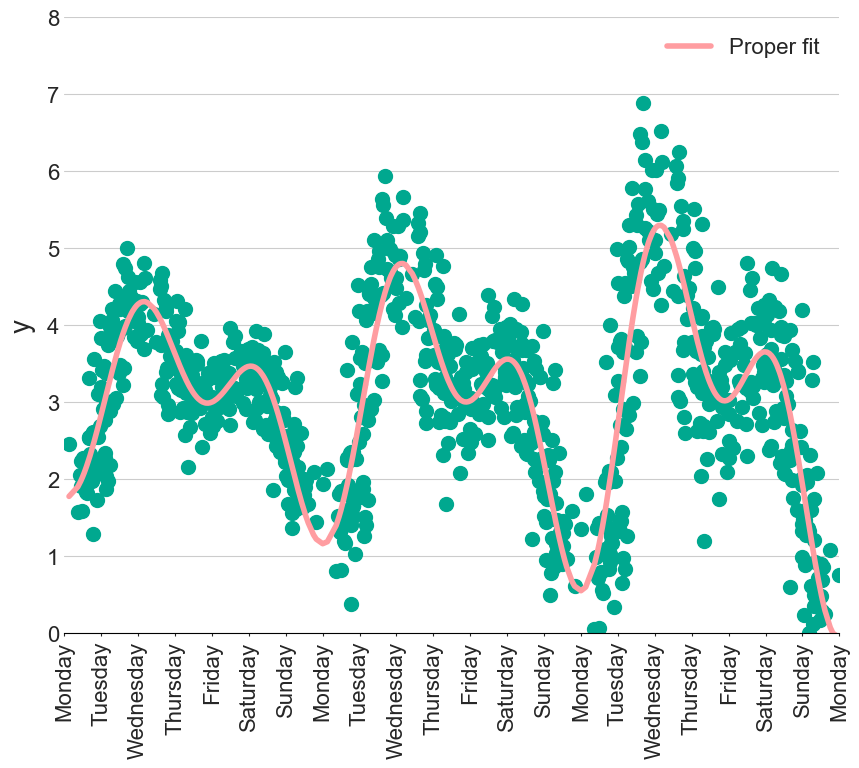

In [73]:
df = data.copy(deep = True)

df['cos_1'] = fourier_component(df['x']/7, "cos", 1)
df['sin_1'] = fourier_component(df['x']/7, "sin", 1)
df['cos_2'] = fourier_component(df['x']/7, "cos", 2)
df['sin_2'] = fourier_component(df['x']/7, "sin", 2)

formula = "y ~ x * (cos_1 + sin_1 + cos_2 + sin_2)"

y_train, X_train = patsy.dmatrices(formula, data=df)

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions (optional)
y_pred = model.predict(X_train)

# Evaluate the model (optional)
mse = mean_squared_error(y_train, y_pred)
print(f"Mean Squared Error: {mse}")

# Coefficients and Intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

fig, axs = plt.subplots(1,1, figsize = (10,8))



axs.scatter(df['x'], df['y'])
axs.plot(df['x'], model.predict(X_train), color = tl_colors[1], label = 'Proper fit', lw= 4)
axs.legend()

top_x = 21
axs.set_xlim(0,top_x)
axs.set_ylim(0,8)

# Define the days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set xticks and labels
plt.xticks(np.arange(0, top_x + 1, 1), [days_of_week[int(day) % 7] for day in np.arange(0, top_x + 1, 1)], rotation=90)

axs.set_ylabel('y')

interaction terms create a massive number of features so we need to keep control of them

# Avoiding Overfitting

One of the hardest parts of fitting any model, either simple or complex, is making sure we don't overfit. We want to model the general shape of the observed data, but do not want to be perfect on every point, as this will just be noise.


We can combat this with a technique called "regularisation". Basically, we add a penalty term to the regression formula. Therefore, the model will be penalised for each variable it adds, so it needs to be really sure it is a useful feature before adding it. THis is normally specified with an `alpha` parameter

> The alpha parameter specifies a trade-off between the model's performance on the training set and its simplicity. So, increasing the alpha value (its default value is 1.0) simplifies the model by shrinking the coefficients.


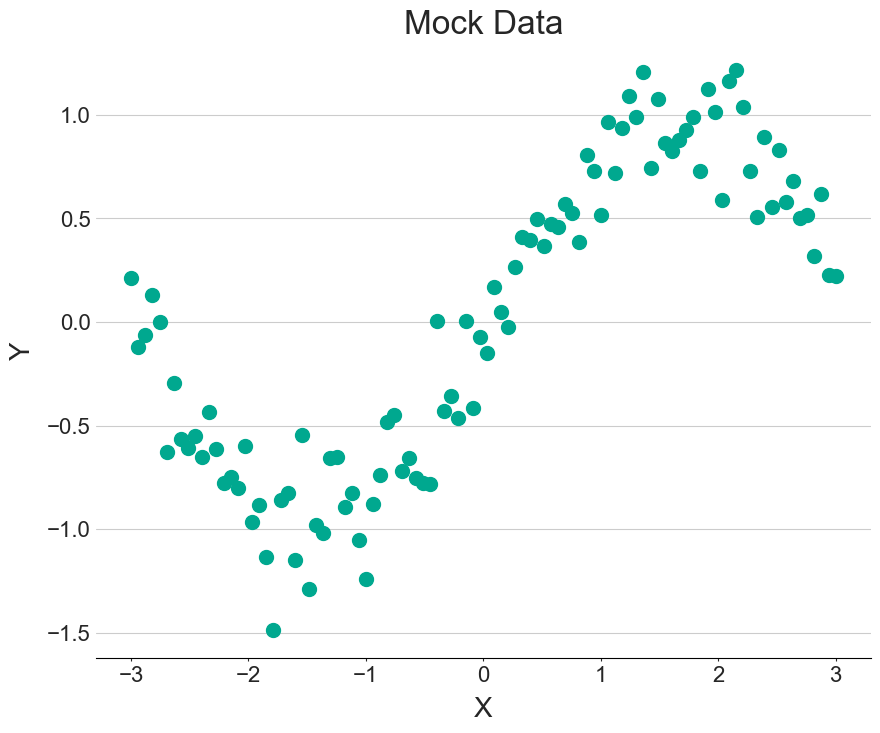

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Generating mock data
np.random.seed(0)
x = np.linspace(-3, 3, 100)
y = np.sin(x) + np.random.normal(0, 0.2, 100)  # Sinusoidal data with noise

# Plotting the mock data
plt.scatter(x, y)
plt.title("Mock Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Text(0.5, 0, 'Polynomial order')

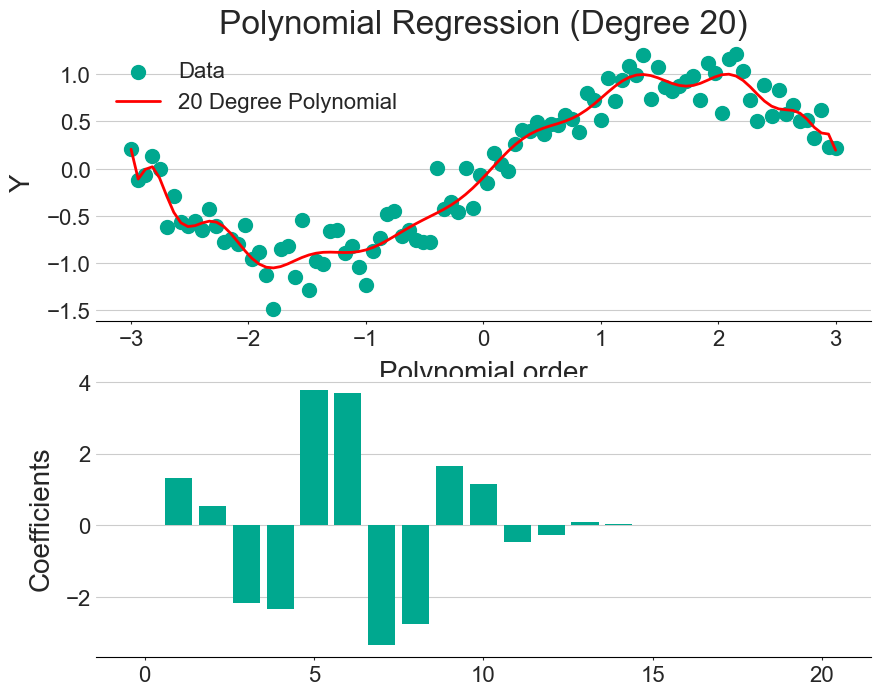

In [75]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Function to fit polynomial regression
def polynomial_regression(degree, X, Y):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X[:, np.newaxis], Y)
    return model

# Fitting a high-degree polynomial (e.g., 15th degree)
degree = 20
model = polynomial_regression(degree, x, y)


# Plotting the polynomial regression
fig, axs = plt.subplots(2,1)

axs[0].scatter(x, y, label="Data")
axs[0].plot(x, model.predict(x[:, np.newaxis]), color='red', label=f"{degree} Degree Polynomial")
axs[0].set_title(f"Polynomial Regression (Degree {degree})")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].legend()


# Access the lasso model in the pipeline
model = model.named_steps['linearregression']

# Get the coefficients
coefficients = model.coef_

# The intercept is also part of the model parameters
intercept = model.intercept_

axs[1].bar(np.arange(len(coefficients)), coefficients)
axs[1].set_ylabel('Coefficients')
axs[0].set_xlabel("Polynomial order")

c:\Users\ronanl\AppData\Local\anaconda3\envs\linear_models\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.638e+00, tolerance: 5.341e-03
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 0, 'Polynomial order')

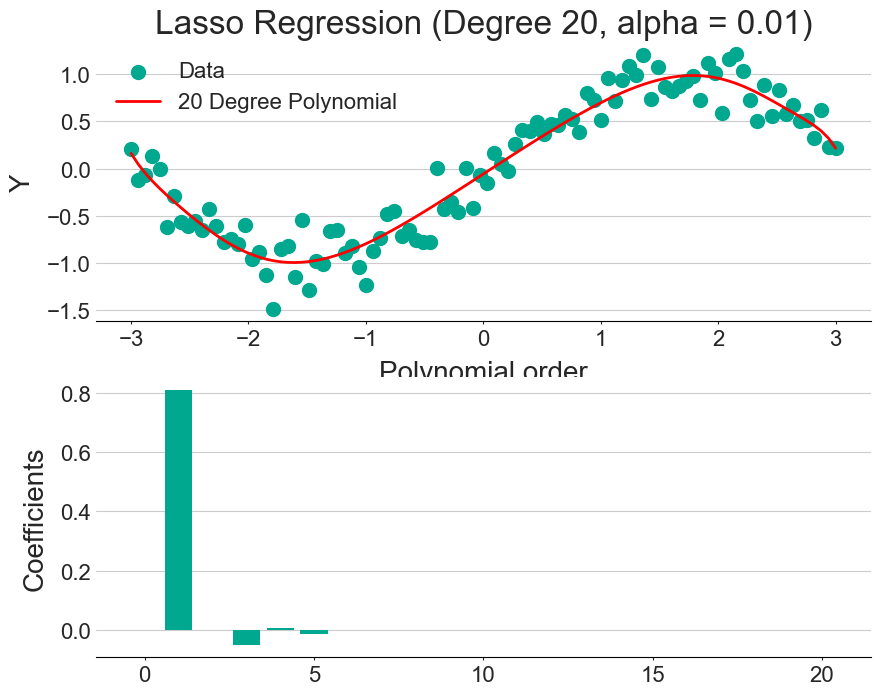

In [76]:
from sklearn.linear_model import Ridge, Lasso

# Function to fit polynomial regression with ridge regularization
def lasso_polynomial_regression(degree, X, Y, alpha):
    model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    model.fit(X[:, np.newaxis], Y)
    return model

# Fitting with ridge regularization
alpha = 0.01  # Regularization strength
degree = 20
lasso_model = lasso_polynomial_regression(degree, x, y, alpha)

# Plotting the polynomial regression
fig, axs = plt.subplots(2,1)

axs[0].scatter(x, y, label="Data")
axs[0].plot(x, lasso_model.predict(x[:, np.newaxis]), color='red', label=f"{degree} Degree Polynomial")
axs[0].set_title(f"Lasso Regression (Degree {degree}, alpha = {alpha})")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].legend()


# Access the lasso model in the pipeline
lasso_model = lasso_model.named_steps['lasso']

# Get the coefficients
coefficients = lasso_model.coef_

# The intercept is also part of the model parameters
intercept = lasso_model.intercept_

axs[1].bar(np.arange(len(coefficients)), coefficients)
axs[1].set_ylabel('Coefficients')
axs[0].set_xlabel("Polynomial order")


# Prophet

The [prophet model](https://facebook.github.io/prophet/) from Facebook provides many of these functionalities straight out of the box. It also has a few tricks up its sleeves, e.g. it can model increases in sales on holidays in that region. Prophet can also handle growth (along with changepoints), as well as deal with gaps in the data.

[Full documentation](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events)

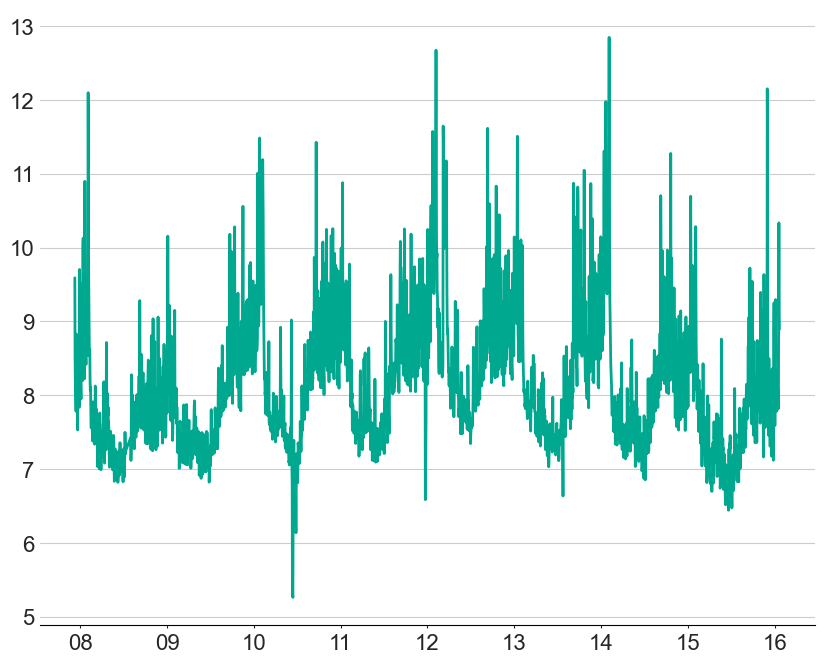

In [49]:
# Python
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv', parse_dates=['ds'])
df.head()

plt.figure()
plt.plot(df['ds'], df['y'])

We can model growth very easily in prophet. Either linear growth (straight line), or logistic growth. For this latter option, we have to tell it the maximum value of the underlying growth trend.

We can also specify the number of Fourier orders to use for yearly seasonality.

In [54]:
m = Prophet(
    weekly_seasonality = True,
    yearly_seasonality=5
)

m.add_country_holidays(country_name='USA')

m.fit(df)


future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

13:31:05 - cmdstanpy - INFO - Chain [1] start processing
13:31:06 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.158288,7.477113,8.868420
3266,2017-01-16,9.224698,8.513354,9.910902
3267,2017-01-17,8.265702,7.562098,9.022792
3268,2017-01-18,8.094456,7.355305,8.864747
3269,2017-01-19,8.112152,7.427264,8.903608


c:\Users\ronanl\AppData\Local\anaconda3\envs\linear_models\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ronanl\AppData\Local\anaconda3\envs\linear_models\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


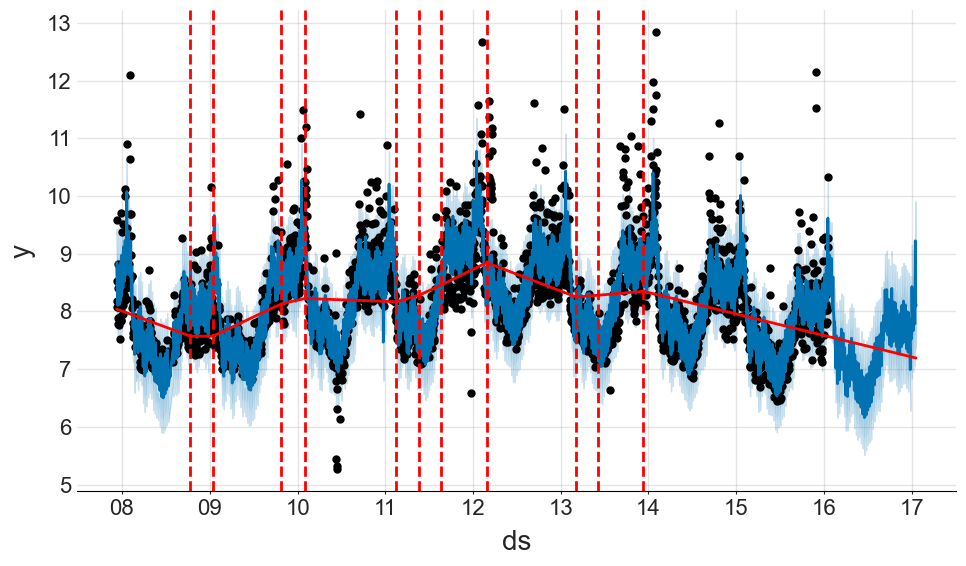

In [55]:
%matplotlib inline
from prophet.plot import add_changepoints_to_plot


fig = m.plot(forecast)
ax = fig.gca()
a = add_changepoints_to_plot(ax, m, forecast)


It was really that easy to get a basic prediction with prophet. It turns out, prophet is just using some of the tricks from earlier:
- Is a linear model
- Models weekly seasonality with Radial Basis Function dummy variables
- Models yearly seasonality with Fourier components
- Can fit in a Bayesian way, giving uncertanties in the predictions

For a more detailed tutorial see the [official documentation](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events)

We can also break down each of these components to extract more information

c:\Users\ronanl\AppData\Local\anaconda3\envs\linear_models\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ronanl\AppData\Local\anaconda3\envs\linear_models\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\ronanl\AppData\Local\anaconda3\envs\linear_models\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a

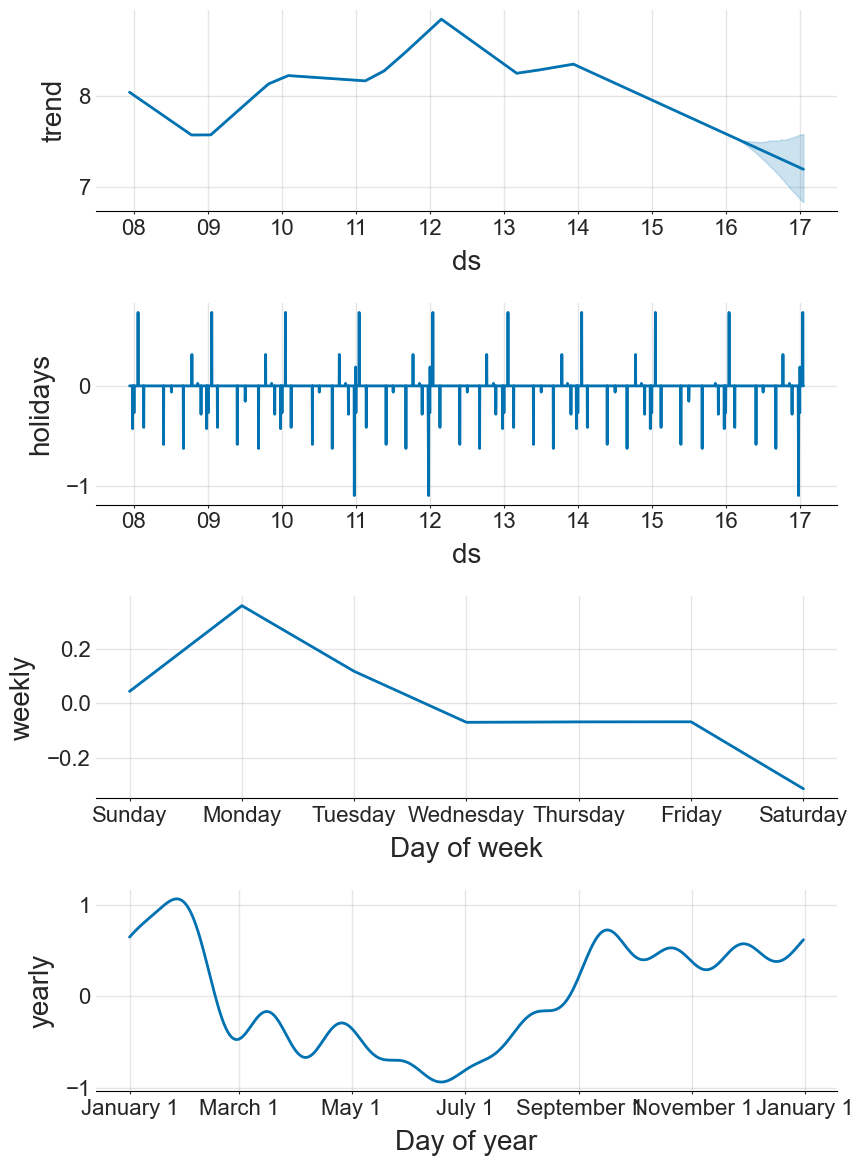

In [56]:
fig = m.plot_components(forecast)

# Appendix





## Draw the data

This is a neat little package to draw fake data from within Juptyer notebooks.

I used it to create the fake seasonality data

In [2]:
from drawdata import draw_line, draw_histogram, draw_scatter

draw_scatter()